# 4 Time series features

[FPP3 Chapter 3](https://otexts.com/fpp3/features.html)

* [4.1 Some simple statistics](#4.1-Some-simple-statistics)
* [4.2 ACF features](#4.2-ACF-features)
* [4.3 STL Features](#4.3-STL-Features)
* [4.4 Other Features](#4.4-Other-Features)
* [4.5 Exploring Australian tourism data](#4.5-Exploring-Australian-tourism-data)

Things are going to be extra manual in this chapter, compared to the equivalents in R.  I'll touch briefly on [tsfresh](https://tsfresh.readthedocs.io/en/latest/), but that seems much more like cookie-cutter feature engineering for production, rather than a tool for any kind of inference.

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

# extra import for feature engineering
import tsfresh

# also sklearn for a little PCA + t-SNE
from sklearn import preprocessing, decomposition, manifold

[utils.py](utils.py)

## 4.1 Some simple statistics

[FPP3 Section 4.1](https://otexts.com/fpp3/some-simple-statistics.html)

In [2]:
tourism = (
    pd.read_csv('data/tourism.csv')
    .pipe(compute, lambda x: dict(
        date=pd.to_datetime(x.Quarter.str.replace(' ', ''))
    ))
    .set_index('date', drop=False)
)
tourism

,Quarter,Region,State,Purpose,Trips,date
date,,,,,,
1998-01-01,1998 Q1,Adelaide,South Australia,Business,135.077690,1998-01-01
1998-04-01,1998 Q2,Adelaide,South Australia,Business,109.987316,1998-04-01
1998-07-01,1998 Q3,Adelaide,South Australia,Business,166.034687,1998-07-01
1998-10-01,1998 Q4,Adelaide,South Australia,Business,127.160464,1998-10-01
1999-01-01,1999 Q1,Adelaide,South Australia,Business,137.448533,1999-01-01
...,...,...,...,...,...,...
2016-10-01,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151,2016-10-01
2017-01-01,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014,2017-01-01
2017-04-01,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837,2017-04-01


In [3]:
tourism.groupby('Region State Purpose'.split()).Trips.mean()

Region           State            Purpose 
Adelaide         South Australia  Business    155.527910
                                  Holiday     156.543437
                                  Other        56.563450
                                  Visiting    205.193667
Adelaide Hills   South Australia  Business      2.664236
                                                 ...    
Wimmera          Victoria         Visiting     14.879986
Yorke Peninsula  South Australia  Business      6.892481
                                  Holiday      80.088485
                                  Other         1.885884
                                  Visiting     28.146552
Name: Trips, Length: 304, dtype: float64

In [4]:
(
    tourism
    .groupby('Region State Purpose'.split())
    .pipe(summarize, lambda x: dict(mean=x.Trips.mean()))
    .reset_index()
    .sort_values('mean')
)

,Region,State,Purpose,mean
158,Kangaroo Island,South Australia,Other,0.340347
182,MacDonnell,Northern Territory,Other,0.449004
294,Wilderness West,Tasmania,Other,0.478268
34,Barkly,Northern Territory,Other,0.632386
86,Clare Valley,South Australia,Other,0.897749
...,...,...,...,...
269,Sydney,New South Wales,Holiday,550.326865
217,North Coast NSW,New South Wales,Holiday,587.896632
268,Sydney,New South Wales,Business,602.043884
199,Melbourne,Victoria,Visiting,618.897541


In [5]:
(
    tourism
    .groupby('Region State Purpose'.split())
    .Trips.quantile(np.linspace(0, 1, 5))
    .unstack()
    .reset_index()
)

,Region,State,Purpose,0.0,0.25,0.5,0.75,1.0
0,Adelaide,South Australia,Business,68.725393,133.893462,152.576618,176.935536,242.494367
1,Adelaide,South Australia,Holiday,108.033040,134.626822,153.945007,172.256677,223.557406
2,Adelaide,South Australia,Other,25.901846,43.865901,53.809463,62.523135,107.494657
3,Adelaide,South Australia,Visiting,136.611154,178.915998,205.581736,229.299111,269.535618
4,Adelaide Hills,South Australia,Business,0.000000,0.000000,1.255434,3.920368,28.601515
...,...,...,...,...,...,...,...,...
299,Wimmera,Victoria,Visiting,1.307505,10.800154,13.863049,19.222546,42.516814
300,Yorke Peninsula,South Australia,Business,0.000000,3.161881,5.727692,9.023333,23.062615
301,Yorke Peninsula,South Australia,Holiday,34.078872,58.180385,77.624339,96.779303,138.035726
302,Yorke Peninsula,South Australia,Other,0.000000,0.500451,1.288070,2.789666,13.903678


## 4.2 ACF features

[FPP3 Section 4.2](https://otexts.com/fpp3/acf-features.html)

In [6]:
(
    tourism
    .groupby('Region State Purpose'.split())
    .Trips
    .pipe(summarize, lambda x: dict(
        acf1 = x.shift().corr(x),
        acf10 = np.sum([x.shift(n).fillna(0).corr(x)**2 for n in range(1,11)]),
        diff1_acf1 = x.diff().shift().corr(x.diff()),
        diff1_acf10 = np.sum([
            x.diff().shift(n).fillna(0).corr(x.diff().fillna(0))**2
            for n in range(1,11)]),
        diff2_acf1 = x.diff().diff().shift().corr(x.diff().diff()),
        # etc.
    ))
    .unstack()
    .reset_index()
)

,Region,State,Purpose,acf1,acf10,diff1_acf1,diff1_acf10,diff2_acf1
0,Adelaide,South Australia,Business,0.033747,0.178512,-0.520696,0.467325,-0.680290
1,Adelaide,South Australia,Holiday,0.048006,0.181429,-0.362272,0.667445,-0.508050
2,Adelaide,South Australia,Other,0.520506,1.839437,-0.416583,0.394835,-0.683430
3,Adelaide,South Australia,Visiting,0.069183,0.087223,-0.400511,0.460148,-0.529266
4,Adelaide Hills,South Australia,Business,0.071204,0.118244,-0.579912,0.422009,-0.752904
...,...,...,...,...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.157857,0.074567,-0.399496,0.244883,-0.632037
300,Yorke Peninsula,South Australia,Business,0.031348,0.100111,-0.415320,0.319440,-0.578901
301,Yorke Peninsula,South Australia,Holiday,-0.005335,1.459052,-0.148840,2.271211,-0.260421
302,Yorke Peninsula,South Australia,Other,-0.108659,0.244080,-0.719777,0.973856,-0.796429


Note: doesn't *quite* match https://otexts.com/fpp3/acf-features.html ... close though.

## 4.3 STL Features

[FPP3 Section 4.3](https://otexts.com/fpp3/stlfeatures.html)

In [7]:
d = (
    tourism
    .groupby('Region State Purpose'.split())
    .pipe(summarize, lambda x: dict(
        stl = sm.tsa.STL(x.Trips).fit()
    ))
    .pipe(compute, lambda x: dict(
        trend_strength = [
            1 - (stl.resid.var() / (stl.resid + stl.trend).var())
            for stl in x.stl ],
        season_strength = [
            1 - (stl.resid.var() / (stl.resid + stl.seasonal).var())
            for stl in x.stl ],
    ))
    .reset_index()
    .drop(columns='stl')
)

In [8]:
d

,Region,State,Purpose,trend_strength,season_strength
0,Adelaide,South Australia,Business,0.491401,0.470449
1,Adelaide,South Australia,Holiday,0.602472,0.686141
2,Adelaide,South Australia,Other,0.790447,0.385627
3,Adelaide,South Australia,Visiting,0.494546,0.561827
4,Adelaide Hills,South Australia,Business,0.515058,0.347363
...,...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.566867,0.470856
300,Yorke Peninsula,South Australia,Business,0.484131,0.570480
301,Yorke Peninsula,South Australia,Holiday,0.452712,0.846731
302,Yorke Peninsula,South Australia,Other,0.494873,0.554751


Some region/state/purpose with low or high trend strengths:

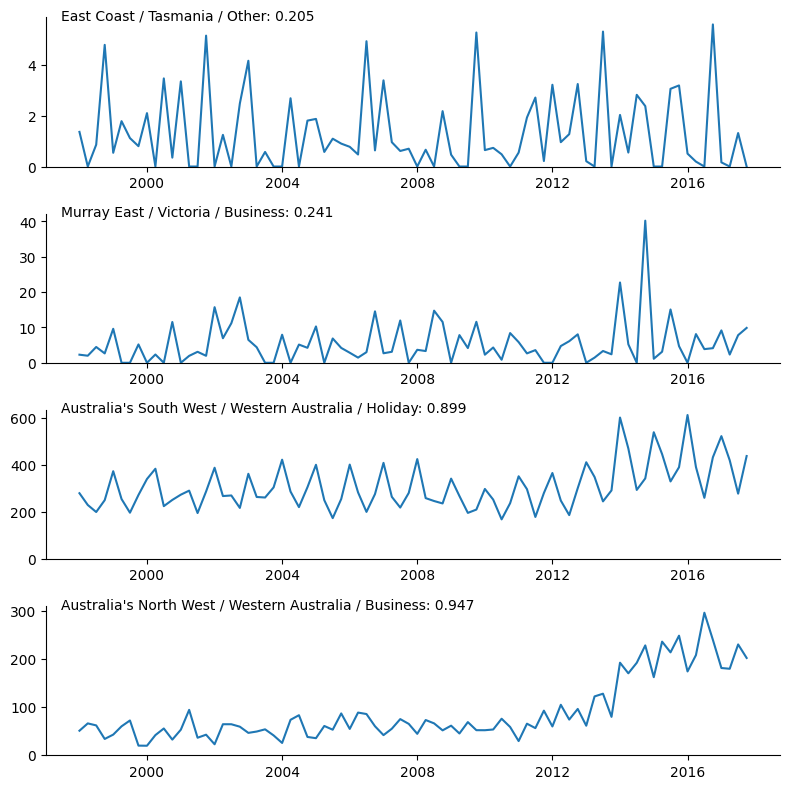

In [9]:
cols = 'Region State Purpose'.split()
fig, axs = plt.subplots(4, 1, figsize=(8,8))
ii = d.sort_values('trend_strength').index[[0, 1, -2, -1]]
for (ax, i) in zip(axs, ii):
    idx = d.loc[i, cols].to_frame().T
    ts = idx.merge(tourism, on=cols).set_index('date')
    ax.plot(ts.Trips)
    ax.text(.02, .98,
            f'{" / ".join(idx.values[0])}: {d.trend_strength.loc[i]:.3f}',
            transform=ax.transAxes)
    ax.set(ylim=(0,None))
plt.tight_layout()

Some region/state/purpose with low or high season strength:

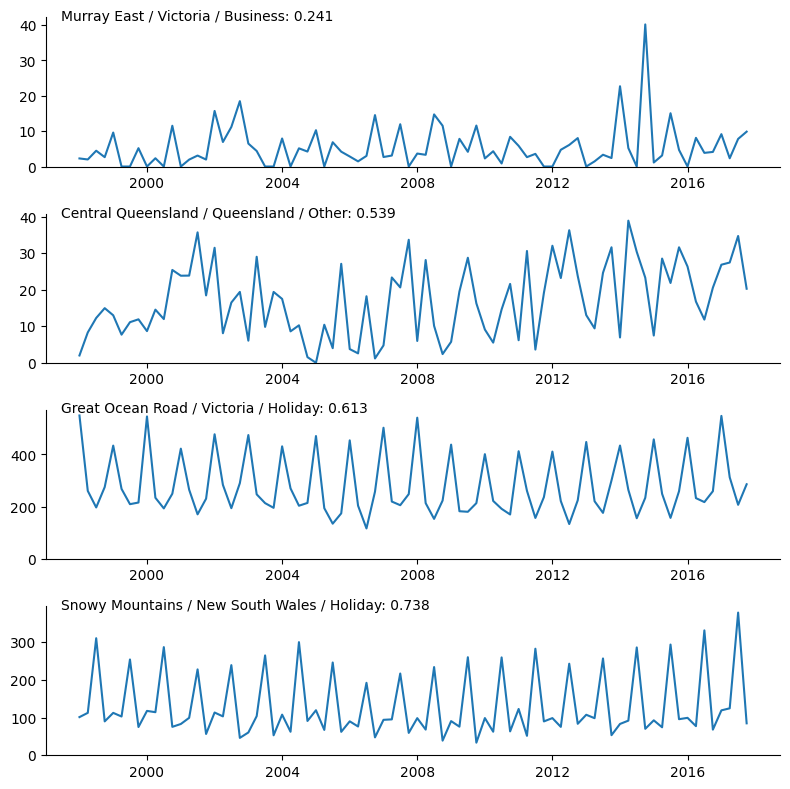

In [10]:
cols = 'Region State Purpose'.split()
fig, axs = plt.subplots(4, 1, figsize=(8,8))
ii = d.sort_values('season_strength').index[[0, 1, -2, -1]]
for (ax, i) in zip(axs, ii):
    idx = d.loc[i, cols].to_frame().T
    ts = idx.merge(tourism, on=cols).set_index('date')
    ax.plot(ts.Trips)
    ax.text(.02, .98,
            f'{" / ".join(idx.values[0])}: {d.trend_strength.loc[i]:.3f}',
            transform=ax.transAxes)
    ax.set(ylim=(0,None))
plt.tight_layout()

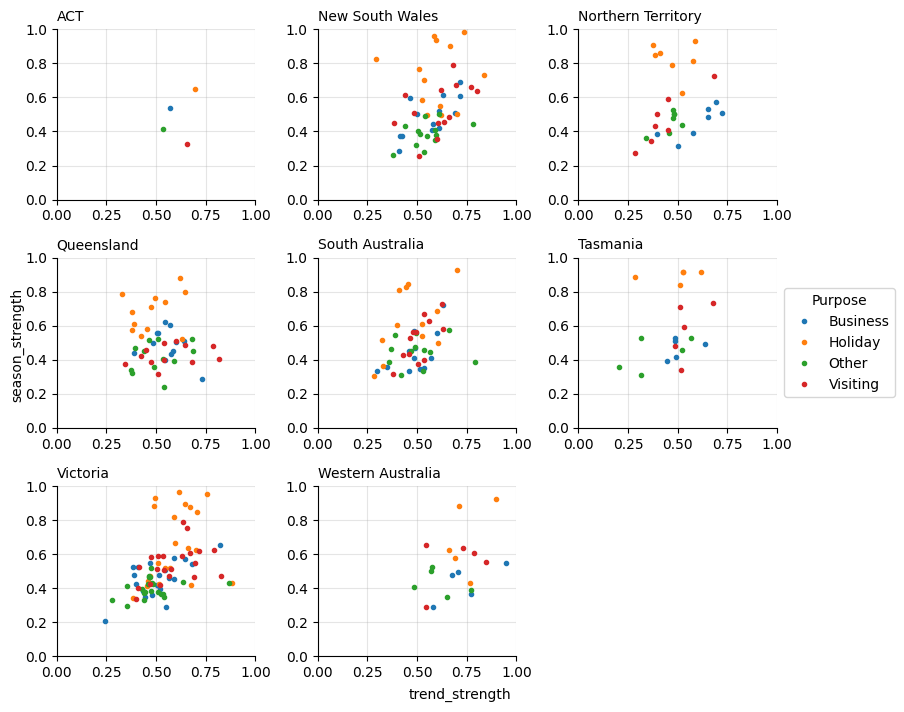

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(9,7))
axs = axs.ravel()
for (i, (State, dd)) in enumerate(d.groupby('State')):
    ax = axs[i]
    for (Purpose, ddd) in dd.groupby('Purpose'):
        ax.plot(ddd.trend_strength, ddd.season_strength, '.', label=Purpose)
    lim = (0, 1)
    ax.set(xlim=lim, ylim=lim, title=State)
    ax.grid()
axs[5].legend(title='Purpose', loc='center left', bbox_to_anchor=[1, .5])
fig.text(.5, -.01, 'trend_strength', ha='center', va='bottom')
fig.text(0, .5, 'season_strength', ha='left', va='center', rotation=90)
fig.delaxes(axs[-1])
plt.tight_layout()

Note: there are still plenty more features not computed here.

## 4.4 Other Features

[FFP3 Section 4.4](https://otexts.com/fpp3/other-features.html)

R's `feasts` "computes only a few dozen features that have proven useful in time series analysis."  I haven't seen a drop-in replacement.  Instead, we'll take a quick look at [tsfresh](https://tsfresh.readthedocs.io/en/latest/).

This is basically for when you don't want to spend too much time or effort searching for information hidden in your timeseries.  tsfresh calculates a large list of features that, taken together, are likely to extract most of the available information.

In [12]:
ids = list(zip(tourism.Region, tourism.State, tourism.Purpose))
d = pd.DataFrame(dict(date=tourism.date, ids=ids, Trips=tourism.Trips))
features = tsfresh.extract_features(d, column_id='ids', column_sort='date')

Feature Extraction: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


In [13]:
features.columns

Index(['Trips__abs_energy', 'Trips__absolute_sum_of_changes',
       'Trips__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'Trips__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'Trips__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'Trips__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"',
       'Trips__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"',
       'Trips__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
       'Trips__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
       'Trips__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"',
       ...
       'Trips__symmetry_looking__r_0.9500000000000001',
       'Trips__time_reversal_asymmetry_statistic__lag_1',
       'Trips__time_reversal_asymmetry_statistic__lag_2',
       'Trips__time_reversal_asymmetry_statistic__lag_3',
       'Trips__value_count__value_-1', 'Trips__value_count__value_0',
       'Trips__value_count__value_1', 'Trips

In [14]:
feat = features.dropna(axis=1, how='all').copy()
feat = tsfresh.utilities.dataframe_functions.impute(feat)

In [15]:
feat

variable,Trips__abs_energy,Trips__absolute_sum_of_changes,"Trips__agg_autocorrelation__f_agg_""mean""__maxlag_40","Trips__agg_autocorrelation__f_agg_""median""__maxlag_40","Trips__agg_autocorrelation__f_agg_""var""__maxlag_40","Trips__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Trips__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Trips__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","Trips__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","Trips__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,Trips__symmetry_looking__r_0.9500000000000001,Trips__time_reversal_asymmetry_statistic__lag_1,Trips__time_reversal_asymmetry_statistic__lag_2,Trips__time_reversal_asymmetry_statistic__lag_3,Trips__value_count__value_-1,Trips__value_count__value_0,Trips__value_count__value_1,Trips__variance,Trips__variance_larger_than_standard_deviation,Trips__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
"(Adelaide, South Australia, Business)",2.035497e+06,2954.746823,-0.044595,-0.025129,0.025393,221.255986,156.233078,91.481348,1663.960750,242.494367,...,1.0,89670.072292,99496.333255,110175.257946,0.0,0.0,0.0,1254.784165,1.0,0.227759
"(Adelaide, South Australia, Holiday)",2.018329e+06,2265.919912,0.012693,0.011321,0.050729,194.419573,148.855963,120.058650,477.865172,223.557406,...,1.0,20566.957497,92647.374474,66309.138766,0.0,0.0,0.0,723.263346,1.0,0.171796
"(Adelaide, South Australia, Other)",2.797094e+05,996.938285,0.091202,0.089798,0.049633,60.493478,40.906222,30.142869,82.697131,80.954040,...,1.0,9167.792570,21083.470848,28854.384152,0.0,0.0,0.0,296.944144,1.0,0.304650
"(Adelaide, South Australia, Visiting)",3.451796e+06,2931.877711,-0.026528,-0.023010,0.042046,251.415160,200.217112,158.825170,1050.533961,265.754859,...,1.0,66572.315062,149550.011674,265532.472670,0.0,0.0,0.0,1043.008783,1.0,0.157391
"(Adelaide Hills, South Australia, Business)",2.026174e+03,273.057927,-0.033807,-0.048861,0.011880,11.552803,2.462560,0.000000,14.846271,28.601515,...,1.0,12.033934,-23.623924,-55.557875,0.0,25.0,0.0,18.229021,1.0,1.602540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Wimmera, Victoria, Visiting)",2.211244e+04,629.872028,-0.025746,-0.026336,0.013321,27.742492,16.063097,6.237111,49.165937,42.516814,...,1.0,32.158976,46.587777,209.793009,0.0,0.0,0.0,54.991538,1.0,0.498363
"(Yorke Peninsula, South Australia, Business)",5.842724e+03,429.648591,-0.018201,0.013933,0.016590,17.544497,7.926013,2.469020,22.220187,23.062615,...,1.0,-35.483142,-28.436835,39.223154,0.0,4.0,0.0,25.527750,1.0,0.733045
"(Yorke Peninsula, South Australia, Holiday)",5.671373e+05,2551.395468,-0.000175,-0.014469,0.242493,127.346576,77.891220,41.622135,658.428845,138.035726,...,1.0,-6578.180832,464.907362,2086.774031,0.0,0.0,0.0,675.051287,1.0,0.324413


## 4.5 Exploring Australian tourism data

[FPP3 Section 4.5](https://otexts.com/fpp3/exploring-australian-tourism-data.html)

The main plot from this section is fantastic.  We will make only a very weak knock-off here.

In [16]:
d1 = (
    tourism
    .groupby('Region State Purpose'.split())
    .Trips.quantile(np.linspace(0, 1, 5))
    .unstack()
    .reset_index()
)

d2 = (
    tourism
    .groupby('Region State Purpose'.split())
    .Trips
    .pipe(summarize, lambda x: dict(
        acf1 = x.shift().corr(x),
        acf10 = np.sum([x.shift(n).fillna(0).corr(x)**2 for n in range(1,11)]),
        diff1_acf1 = x.diff().shift().corr(x.diff()),
        diff1_acf10 = np.sum([
            x.diff().shift(n).fillna(0).corr(x.diff().fillna(0))**2
            for n in range(1,11)]),
        diff2_acf1 = x.diff().diff().shift().corr(x.diff().diff()),
        # etc.
    ))
    .unstack()
    .reset_index()
)

d3 = (
    tourism
    .groupby('Region State Purpose'.split())
    .pipe(summarize, lambda x: dict(
        stl = sm.tsa.STL(x.Trips).fit()
    ))
    .pipe(compute, lambda x: dict(
        trend_strength = [
            1 - (stl.resid.var() / (stl.resid + stl.trend).var())
            for stl in x.stl ],
        season_strength = [
            1 - (stl.resid.var() / (stl.resid + stl.seasonal).var())
            for stl in x.stl ],
    ))
    .reset_index()
    .drop(columns='stl')
)
cols = 'Region State Purpose'.split()
d = d1.merge(d2, on=cols).merge(d3, on=cols)

To see how much information we've extracted, we'll do a principle component analysis.  In principle, statsmodels [handles this too](https://www.statsmodels.org/stable/generated/statsmodels.multivariate.pca.PCA.html), but it seems that [sklearn's PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) has better defaults.

In [17]:
X = preprocessing.StandardScaler().fit_transform(d[d.columns[3:]])
pca = decomposition.PCA().fit_transform(X)

In [18]:
dpca = (
    pd.DataFrame(pca)
    .assign(Region=d.Region, State=d.State, Purpose=d.Purpose)
)

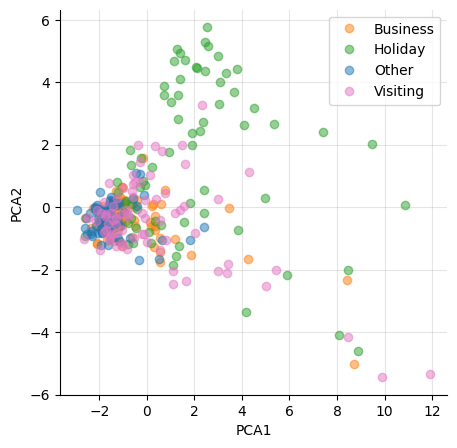

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
colors = dict(Business='C1', Holiday='C2', Other='C0', Visiting='C6')
for (Purpose, dd) in dpca.groupby('Purpose'):
    ax.plot(dd[0], dd[1], 'o', label=Purpose, color=colors[Purpose], alpha=.5)
ax.legend()
ax.set(xlabel='PCA1', ylabel='PCA2')
plt.grid()

### Bonus: t-SNE

[t-SNE](https://scikit-learn.org/stable/modules/manifold.html#t-sne) is another way to make similar visualizations.  It's generally slower, but it packs more info into 2D space.

In [20]:
%%time
tsne = manifold.TSNE(random_state=1).fit_transform(X)

CPU times: user 6.33 s, sys: 112 ms, total: 6.44 s
Wall time: 876 ms


In [21]:
dtsne = (
    pd.DataFrame(tsne)
    .assign(Region=d.Region, State=d.State, Purpose=d.Purpose)
)

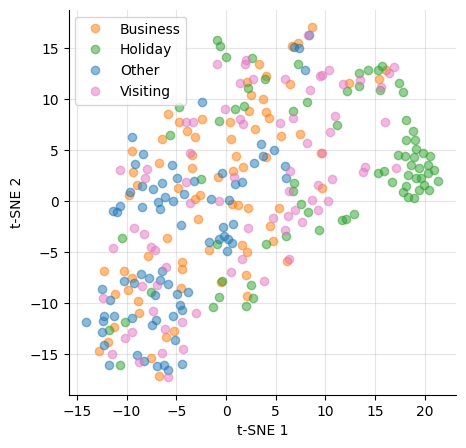

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
colors = dict(Business='C1', Holiday='C2', Other='C0', Visiting='C6')
for (Purpose, dd) in dtsne.groupby('Purpose'):
    ax.plot(dd[0], dd[1], 'o', label=Purpose, color=colors[Purpose], alpha=.5)
ax.legend()
ax.set(xlabel='t-SNE 1', ylabel='t-SNE 2')
plt.grid()

<hr/>

[Previous: Time series decomposition](03-Time-series-decomposition.ipynb)
<br/>
[Next: The forecaster's toolbox](05-The-forecasters-toolbox.ipynb)